# Model Evaluation and Improvement

Some critical concepts needed for assessing ML perf are where we're now headed. These include - 

1. Cross validation k-fold as a concept

2. From Confusion Matrices to Precision and  Recall

3. The ROC curves and the AUC metric

Let's head there right away, with first some synthetic data for illustration. 

I should mention that today we'll also be using two canonical datasets in the process - Iris and MNIST (again?).

Behold.

In [2]:
# setup chunk
import mglearn 
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

Let's start with first some synthetic data for illustrating Cross-Validation

X data shape is:  (100, 2)


Text(0, 0.5, 'X2')

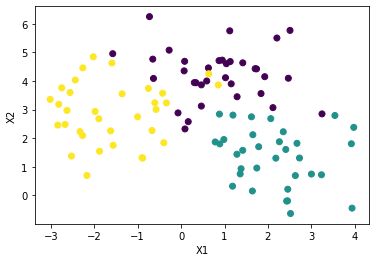

In [3]:
# build dummy dataset and explore it
X, y = make_blobs(random_state=0)
print("X data shape is: ", X.shape)

# plot data to see pattern
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel("X1")
plt.ylabel("X2")

In [4]:
# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)

# evaluate the model on the test set
print("Test set score: ", round(logreg.score(X_test, y_test),3))

Test set score:  0.88


So far so good. Stuff we've seen already. Now, to introduce a new topic.

## Cross validation (CV)

Recall the train-test split? Whole point of splitting away a test sample is to assess model perf on fresh, unseen data and thereby estimate model generalizability etc.

However, the 'randomly' obtained training and test samples are NOT guaranteed to be representative. 

It may very well happen that a model trasined on a particular training sample will behave differently from one trained on a different cut of the same original data!

Hence, it is prudent to train and re-train model on different cuts of the data and thereafter test model perf on different test samples.

Enter CV, a structured way to resample, retrain and revalidate model perf. What kinda structure? See below.

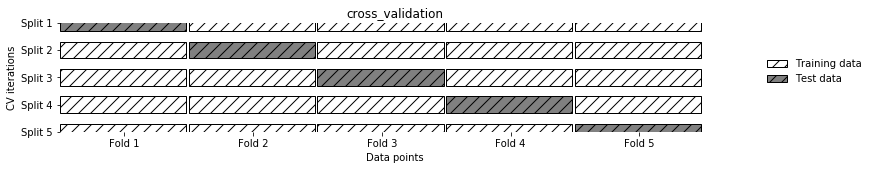

In [5]:
mglearn.plots.plot_cross_validation()

Clearly, we partition a dataset into 'k' different equisized *folds*. One fold of data is held out as test sample and model is trained on the remaining (k-1) samples.

Next loop, another fold is held out as test and model is retrained on the remaining (k-1) as training sample, etc.

Thus, we train and run the model k times in k-fold cross-validation. We obtain k sets of validation set results.

Variance in the k test set results is informative. sklearn has convenient, inbuilt routines to handle different CV types and methods.

Below, I demo the familiar logReg model on the canonical Iris dataset.

### CV on Iris

In [9]:
# Cross-Validation in scikit-learn
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

# loading iris data
iris = load_iris()
logreg = LogisticRegression(max_iter=500)  # Instantiating model

# cross_val_score requires 3 arguments. 5-fold is default
scores = cross_val_score(logreg, iris.data, iris.target)
scores1 = [round(x,3) for x in scores]
print("Cross-validation scores:\n", scores1)
print("\n")
print("Average cross-validation score: ", round(scores.mean(),3))

Cross-validation scores:
 [0.967, 1.0, 0.933, 0.967, 1.0]


Average cross-validation score:  0.973


In [10]:
# doing 3-fold CV instead
scores = cross_val_score(logreg, iris.data, iris.target, cv=3)
scores1 = [round(x,3) for x in scores]
print("Cross-validation scores:\n", scores1)
print("\n")
print("Average cross-validation score: ", round(scores.mean(),3))


Cross-validation scores:
 [0.98, 0.96, 0.98]


Average cross-validation score:  0.973


CV has been so important that numerous funcs in sklearn provide a plethora of outputs, afford minute control over splitting etc and soon.

Below I only show one demo of some of the outputs yielded.

In [11]:
## using cross_validate
from sklearn.model_selection import cross_validate
res = cross_validate(logreg,   # instantiated model
                     iris.data,  # data
                     iris.target, # label
                     cv=5,  # num of folds
                     return_train_score=True)  # retruns training sample acucracy scores too

print(type(res))   # dict

# store in a DF for nicer output views
df0 = pd.DataFrame.from_dict(res)
df0

<class 'dict'>


,fit_time,score_time,test_score,train_score
0,0.041686,0.000999,0.966667,0.966667
1,0.051971,0.000000,1.000000,0.966667
2,0.041974,0.001003,0.933333,0.983333
3,0.038975,0.000000,0.966667,0.983333
4,0.037981,0.000998,1.000000,0.975000


# Metrics to Evaluate Models

We here deconstruct the confusion_matrix and extract metrics of interest viz. 
- Precision, 
- Recall and the 
- F1 score (which combiones Precision and Recall).

These metrics in turn lead us to two important graphical assessment tools for ML models, namely, 
1. Precision-Recall curves
2. Receiver Operating Characteristic (ROC) curve and the Area Under this Curve (AUC)

Next, we'll wade into, for intuition and understanding purposes with simple demo examples the 
- what
- when
- when not
- where
- how
of these evaluation metrics and measures.

Let's set sail. All aboard!

In [12]:
# re-loading the MNIST dataset for our sample applcn
from sklearn.datasets import fetch_openml
import time

t1 = time.time()
mnist = fetch_openml('mnist_784', version=1, cache=True)
t2 = time.time()
print("MNIST import took: ", round(t2-t1, 3), " secs")  # 30.7 secs!
print("\n")

# explore dataset
print("Dataset dimns are: ", mnist.data.shape)   # data size dimns
print(mnist.target.shape)  # labels colm
print("\n")

MNIST import took:  35.429  secs


Dataset dimns are:  (70000, 784)
(70000,)




Next we head to train-test-split. But with a twist. We want that every fold of every sample have every digit present.

Moreover, some ML models are sensitive to the order in which the samples arrive. Randomization should help. 

So I invoke a **shuffle splitter**. See below.

In [13]:
# define X, y
X, y = mnist["data"], mnist["target"]

# split into 60k training set and 10k test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# imposing shuffle requirement, home brewed
import numpy as np
shuffle_index = np.random.permutation(60000)  # random index set
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]  # shuffled training set

## Training a Binary Classifier

Say our (simplified) task is only to predict whether a digit is a '5' versus not. Hence, binary classification.

I intro the **Stochastic Gradient Descent (SGD) classifier** as one of the methods we evaluate. Partly because it is efficient on large samples. See below.

In [14]:
# set new target set of labels
y_train_5 = (y_train == '5')  # creates logcal vectors
print("a few elements of y_train_5: ", y_train_5[:10])  # view 
y_test_5 = (y_test == '5')

# import and train classifier on training data
from sklearn.linear_model import SGDClassifier
t1 = time.time()
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)
print(round(time.time()-t1, 3), "secs")  # 0.5 secs for 60k samples. Fast!

a few elements of y_train_5:  [False False False False False False False False False False]
0.489 secs


Time to see how well the SGDclassifier predicts on test data.

To do that, let me first show you some instances in the data which are '5' versus 'non-5'.

In [15]:
print(y_test[121:140])  # how many 5s are there?
print(sgd_clf.predict(X_test[121:140]))  # how many 5s were correctly classified?
print("\n")
disp_df = pd.DataFrame({'actual_y':y_test[121:140], 'predicted_y':sgd_clf.predict(X_test[121:140])})
disp_df


['4' '7' '6' '7' '9' '0' '5' '8' '5' '6' '6' '5' '7' '8' '1' '0' '1' '6'
 '4']
[False False False False False False  True False  True False False  True
 False False False False False False False]




,actual_y,predicted_y
0,4,False
1,7,False
2,6,False
3,7,False
4,9,False
5,0,False
6,5,True
7,8,False
8,5,True
9,6,False


## Performance Measures

Well, how well did we do?  Need some standard perf metrics to assess this.

And would perf change by a lot if we'd *randomly* picked a different train-test sample instead? Need cross-validation to see this.

Let's find out below. 

In [17]:
# running 3-fold cv to check robustness
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(cv_score)
print("\n")
round(cv_score.mean(), 3)

[0.9465  0.95455 0.96645]




0.956

Wow. ~ 95% accuracy! We must be on roll, eh?

Lest we get too excited, let's see how well a *Dumb Classifier* does on the same data. 

### Compare against a Dummy Classifier

Behold.

In [18]:
from sklearn.dummy import DummyClassifier

# define 'most freq' as dummy rule for this classifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train_5)
pred_most_frequent = dummy_majority.predict(X_test)

# now check perf of dummy clfr
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test_5)))

Unique predicted labels: [False]
Test score: 0.91


91%!

Unsurprising in hindsight since only about 10% of the digits randomly speaking, would be fives.

So even with dummy classifiers, we get 90% accuracy, without learning anything.

Common problem in 'unbalanced' (in this case, seriously *skewed* datasets).

A confusion matrix provides us a way out - to evolve better metrics to measure ML classifier perf better.

## Confusion Matrices and Derivatives

In [20]:
# combining CV with clfr prediction
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# building a confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_train_5, y_train_pred)

df1 = pd.DataFrame(conf_mat, columns=['pred_not5', 'pred_5'], index=['actual_not5', 'actual_5'])
df1                   

,pred_not5,pred_5
actual_not5,53099,1480
actual_5,1170,4251


Clearly quite a few cases where true 5s went undetected (False negatives) and even more where non-5s were misidentified as 5s (False Positives).

Let me head briefly to the slides to better explain the structure and construction of the confusion matrix and the measures that obtainfrom it - Precision and Recall.

### Precision Recall Tradeoff

In [21]:
from sklearn.metrics import precision_score, recall_score

preci = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print("Precision in digit-5 case was: ", round(preci, 2))
print("\n")
print("Recall in digit-5 case was: ", round(recall, 2))

Precision in digit-5 case was:  0.74


Recall in digit-5 case was:  0.78


Well, now things don't look so shiny do they? 

Precision is measly at 74% (against dummy scores of 91% BTW), and the recall metric too points to a serious conern.

Seems like our model only captures about 78% of all true-5s in the Training data!

Precision and Recall measure different things and are informative in different contexts. (Head to slides for more on this)

### F1 score

Often we may want to combine the properties of both Precision and Recall into a single metric. Enter the 'f1' score. Behold.


In [22]:
from sklearn.metrics import f1_score
print("f1 score was: ", round(f1_score(y_train_5, y_train_pred), 2))

f1 score was:  0.76


F1 score by construction favors models that have similar precision and recall.

In instances where high Precision is required (ensure whatever is identified as positive is indeed positive) such as Video-Ratings-for-kids or the drug-discovery-screening-process, we may deliberately favor ML models that do Precision very well even if Recall is iffy.

In other instances, where high Recall is needed i.e., False Negatives can be tolerated such as shoplifting-surveillance or cancer-screening, we prefer algos with better Recall perf.

Normally, an algo's decision function gives score of '1' over '0' if probability exceeds 50%. However, we can tinker with this and set high (or low)  **decision thresholds** if we want high precision (high recall). 

Unforunately, can't have it both ways. Raising Precision pulls down Recall and vice-versa. Also called the Precision-recall tradeoff.

Next, I plot how the Precision of an ML algo varies with change in decision threshold (the **'precision curve'**) and do likewise for **Recall curves** too. 

Behold.

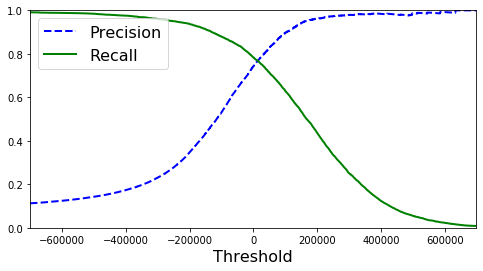

In [23]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# define func that uses above scores and plots the P-R curves
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

sklearn disallows directly setting decision thresholds but gives access tro decision func scores which is what I used to work around and get to P-R curves.

Oft helpful to plot Precision directly against recall. See below.

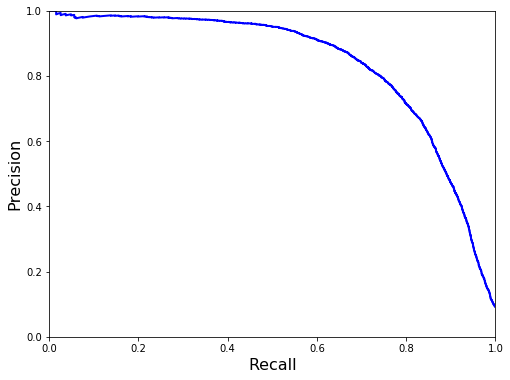

In [24]:
# define func to plot P-R curves directly
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

Closer the curve is to the top right, better the algo's perf (since both P and R are high).

From curve above, easy to see that precision starts to fall off rather sharply around 70% recall. We may want a P-R tradeoff just before that drop happens, say around 2/3rds or something. Depends on context of course.

Time now to move to the last of perf measures, 

### the ROC and the AUC.

Let' first head to the slides before this maybe?

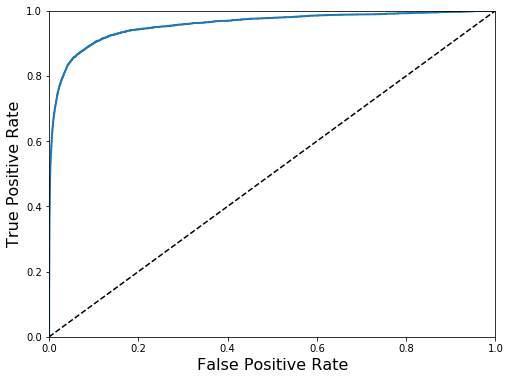

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# define plotting func for ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

How to read the ROC curve? 

The y-axis is **sensitivity** and measures the TPR. Higher the better, of course. Corresponds to Precision.

The x-axis is the FPR, also called the **1-Specificity** since the FNR is often called Specificity. The more specific a model to detecting True Positives, the more it disallows false negatives from happening.

Closer a model's ROC is to the top left corner, better its perf.

### The  Area Under the Curve (AUC)

Sometimes, when comparing multiple ML algos performances, it makes sense to reduce the entire ROC curve to 1 perf metric. This is the area under the ROC curve, or simply AUC. A single number measure of classifier perf across varying sample compositions and skew.

Behold.

In [26]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train_5, y_scores)
print("AUC is: ", round(auc, 3))

AUC is:  0.957


## Comparing ML Models via AUC

We've done SGD. Let's also see another clfr - the **RandomForest or RF classifier** from the ensemble methods section of the Decision Tree class. 

Let's compare which ML model does better on the same data under varying conditions of precision and recall, sensitivity and specificity. 

Behold.

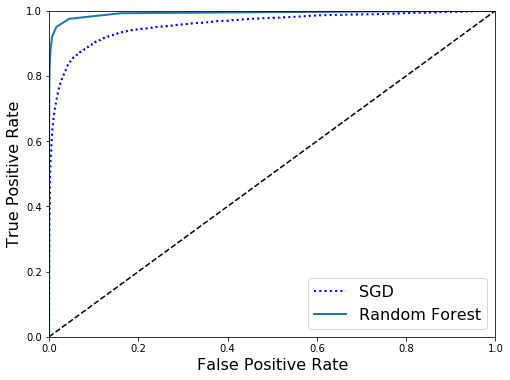

In [27]:
# instantiate RF clfr
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

# obtain decision scores for RF
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

# plot overlaying SGD vs RF
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

No doubt the RF outperforms SGD on just about every metric under the sun, on this dataset. AUC is clearly higher. See below.

In [28]:
auc_rf = roc_auc_score(y_train_5, y_scores_forest)
print("AUC of RF is: ", round(auc_rf, 3))
print("\n")

# find also P and R scores for RF algo
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
preci_rf = precision_score(y_train_5, y_train_pred_forest)
recall_rf = recall_score(y_train_5, y_train_pred_forest)

print("RF Precision is: ", round(preci_rf, 3))
print("\n")
print("RF Recall is: ", round(recall_rf, 3))

AUC of RF is:  0.992


RF Precision is:  0.984


RF Recall is:  0.821


Chalo, time to head back to slides now.

Voleti.